Instructions on running this notebook!
1. Register for an account at Google Earth Engine  at __[earth engine account](https://earthengine.google.com/platform/)__
2. Authenticate your earth engine account
3. Download the needed shapefile from __[here](https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_MOZ_shp.zip)__
4. Unzip the downloaded file and replace the directory(country_shp) with the location of the extracted files


In [15]:
# Check geemap and ipygee installation
import subprocess

try:
    import geemap
    import ipygee
except ImportError:
    print('geemap package is not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])
    subprocess.check_call(["python", '-m', 'pip', 'install', 'ipygee'])

In [1]:
#This notebook is implemented using google earth engine, an account authentication and initialization will be required!

import ee
 
# Trigger the authentication flow.
ee.Authenticate()
 
# Initialize the library.
ee.Initialize()



#Import the neccesary packages
import pandas as pd
import altair as alt
import ipygee as ui
import numpy as np
import folium
import math
import geemap
import json
import os
import requests
from geemap import geojson_to_ee, ee_to_geojson
import geemap.chart as chart
from ipyleaflet import GeoJSON


Enter verification code: 4/1AX4XfWhzuEQBzcU_ytFRWOtu_PzUh7GsSorksNfvgaOHlvZthvwCUdbXLa4

Successfully saved authorization token.


In [2]:
#Defining the area of interest to collect data
country_shp = (r'C:\Users\bright\Desktop\aim_ishango\data\gadm36_MOZ_shp\gadm36_MOZ_1.shp')
country = geemap.shp_to_ee(country_shp)

file_path = os.path.abspath(r'C:/Users/bright/Desktop/aim_ishango/data/area.geojson')

if not os.path.exists(file_path):
    url = 'https://github.com/bright-aimable/teambright-aimable/blob/main/data/area.geojson'
    r = requests.get(url)
    with open(file_path, 'w') as f:
        f.write(r.content.decode("utf-8"))        

with open(file_path) as f:
    json_data = json.load(f)
    
coords = json_data['features'][0]['geometry']['coordinates']
AOI = ee.Geometry.Polygon(coords)

#SAR band-C collection for crop identification using the backscatter value from the two polarizations VV and VH
S1_Collection =  (ee.ImageCollection('COPERNICUS/S1_GRD')
           .filterBounds(AOI)
           .filterDate(ee.Date('2019-01-01'),ee.Date('2019-12-31'))
           .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
           .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
           .filter(ee.Filter.eq('instrumentMode','IW'))
           .filter(ee.Filter.eq('orbitProperties_pass','DESCENDING')))
##Compute and print the number of image available per km2, area of the polygon and the number of images in the collection.
print("The number of image is ",S1_Collection.size().getInfo())

#RGB composite of the area of interest(AOI) from the dual polarization of the synthentic aperture radar(SAR) Sentinel 1
#Create empty map
RGB = geemap.Map()
RGB.addLayerControl()
#Set the location of the map
RGB.addLayer(AOI,{},'Area of interest')
RGB.addLayer(country,{},'Country of interest')
RGB.centerObject(AOI,13)
RGB.add_basemap('SATELLITE')

# Make an RGB color composite image (VV,VH,VV/VH).
rgb = ee.Image.rgb(S1_Collection.first().select('VV'),
                   S1_Collection.first().select('VH'),
                   S1_Collection.first().select('VV').divide(S1_Collection.first().select('VH')))
# Add the S1 rgb composite to the map object.
RGB.addLayer(rgb, {'min': [-20, -20, 0], 'max': [0, 0, 2]}, 'RGB')


RGB

The number of image is  117


Map(center=[-13.352479341867271, 35.51879882812497], controls=(WidgetControl(options=['position', 'transparent…

Now we classify the tobacco pixels in the SAR images. We will use a simple threshold approach to identify the plant. We will pick a threshold of backscatter and classify all pixels below that threshohld as Tobacco. Emperical evidence suggest that tobacco has a backscatter value in the randge of -17.876 to -19.235 to give us a ballpark estimate of the tobacco area. This threshold is simply based on a similar research done, try adjusting the threshold and see how your classification changes. Optimal thesholds can be determined through comparison with a training dataset, or through more robust statstical techniques. This is a first approach

In [3]:
####Create  map 
compositemap = geemap.Map()
compositemap.addLayerControl()
country_shp = (r'C:\Users\bright\Desktop\aim_ishango\data\gadm36_MOZ_shp\gadm36_MOZ_1.shp')
country = geemap.shp_to_ee(country_shp)
###Funtion to remove edge distortion in the image collection
def mask (image):
    edge = image.lt(-30)
    maskedImage = image.mask().And(edge.Not())
    return image.updateMask(maskedImage)

#SAR band-C collection for crop identification using the backscatter value from the two polarizations VV and VH without date filter
VVcollection = (ee.ImageCollection('COPERNICUS/S1_GRD')
           .filterBounds(AOI)
           .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
           .filter(ee.Filter.eq('instrumentMode','IW'))
           .map(mask)
           #.filter(ee.Filter.eq('orbitProperties_pass','DESCENDING'))
           .select(['VV']))
##Compute and print the number of image available per km2, area of the polygon and the number of images in the collection.
print("The number of image is ",VVcollection.size().getInfo())
#SAR band-C collection for crop identification using the backscatter value from the two polarizations VV and VH without date filter
VHcollection = (ee.ImageCollection('COPERNICUS/S1_GRD')
           .filterBounds(AOI)
           .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
           .filter(ee.Filter.eq('instrumentMode','IW'))
           .filter(ee.Filter.eq('orbitProperties_pass','DESCENDING'))
           .select(['VH']))
##Compute and print the number of image available per km2, area of the polygon and the number of images in the collection.
print("The number of image is ",VVcollection.size().getInfo())

#images based on ascending and descending orbit pass
desc = VVcollection.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
asc = VVcollection.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
#Seasonal composites with planting, harvest and post harvest times 
VV1 = ee.Filter.date('2019-01-01','2019-04-30')
VV2 = ee.Filter.date('2019-05-01','2019-08-31')
VV3 = ee.Filter.date('2019-09-01','2019-12-31')
#filtering date and means of different cropping calender
descChange = ee.Image.cat(
        desc.filter(VV1).mean(),
        desc.filter(VV2).mean(),
        desc.filter(VV3).mean());

ascChange = ee.Image.cat(
        asc.filter(VV1).mean(),
        asc.filter(VV2).mean(),
        asc.filter(VV3).mean());


The number of image is  1300
The number of image is  1300


In [12]:
compositemap.addLayer(descChange, {'min': -25, 'max': 5}, 'Multi-T Mean ASC',True);
compositemap.addLayer(ascChange, {'min': -25, 'max': 5}, 'Multi-T Mean DESC',True);
compositemap.add_basemap('SATELLITE')
compositemap.centerObject(AOI,13)
##Add legends to the map
#legend_keys = ['Rocks/Built-up/Bur land', 'Crops at early stage', 'Water', 'Sparse vegetation', 'Dense vegation']
#legend_colors = ['#eeeeee', '#e3ed91', '#000000', '#b44747', '#f5eade']
compositemap.add_legend(legend_keys=legend_keys, legend_colors=legend_colors)
compositemap

Map(bottom=1127374.0, center=[-13.352479341867271, 35.51879882812497], controls=(WidgetControl(options=['posit…

In [5]:
#SAR band-C collection for crop identification using the backscatter value from the two polarizations VV and VH with filtering on the date and location
S1_Collection =  (ee.ImageCollection('COPERNICUS/S1_GRD')
           .filterBounds(AOI)
           .filterDate(ee.Date('2019-01-01'),ee.Date('2019-12-31'))
           .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
           .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
           .filter(ee.Filter.eq('instrumentMode','IW'))
           .filter(ee.Filter.eq('orbitProperties_pass','DESCENDING')))
           #.select(['VV']))
##Compute and print the number of image available per km2, area of the polygon and the number of images in the collection.
print("The number of image is ",S1_Collection.size().getInfo())

#Create empty map
classifiedmap = geemap.Map()
classifiedmap.addLayerControl()
#Set the location of the map
classifiedmap.addLayer(AOI,{},'Area of interest')
classifiedmap.addLayer(country,{},'Country of interest')
classifiedmap.centerObject(AOI,13)
classifiedmap.add_basemap('SATELLITE')

The number of image is  117


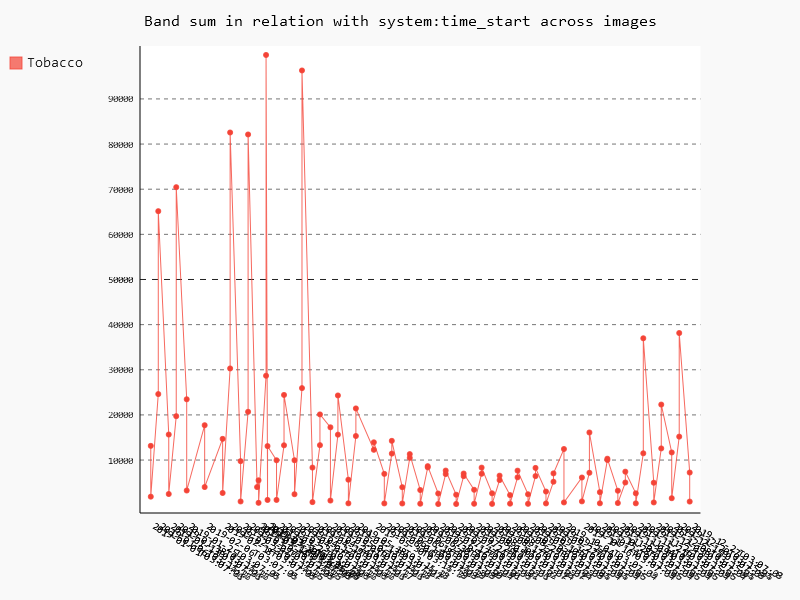

In [6]:
### Classifier built around co polarization vh and vv
def classifier(img):
    vvvh = img.select('VV').add(img.select('VH'))
    Tobacco = vvvh.gt(-19.235).And(vvvh.lt(-17.876)).rename('Tobacco') #pick all pixels below threshold and set them equal to 1. All other pixels set to 0
    Tobacco = Tobacco.updateMask(Tobacco) #Remove all pixels equal to 0
    return img.addBands(Tobacco)#Return image with added classified tobacco band
vvvh_classifier_Tobacco= S1_Collection.map(classifier)

#Make time series of tobacco pixels within region with vh
ClassChart = ui.chart.Image.series(**{'imageCollection': vvvh_classifier_Tobacco.select('Tobacco'),'region': AOI, 'reducer': ee.Reducer.sum(),'scale': 100,'maxPixels':1e9, 'bestEffort':True})

ClassChart.renderWidget(width='100%')
#Define the color pallets and add them to the map
visvh = {min: -20,max: 0,'palette': ['#f44336']}
#classified and visualize the first image
classifiedmap.addLayer( vvvh_classifier_Tobacco.select('Tobacco').median(),visvh,'Tobacco sites')
ClassChart

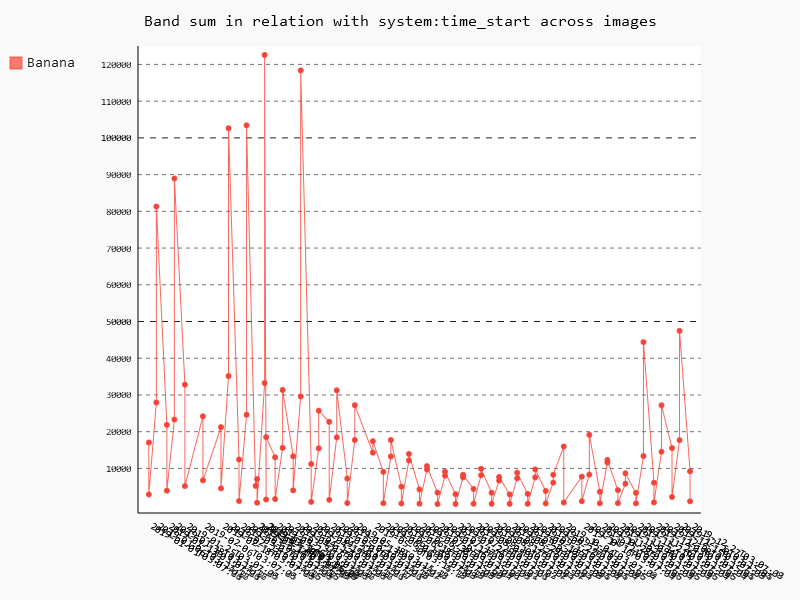

In [7]:
### Classifier built around co polarization vh and vv for banana
def classifier(img):
    vv = img.select('VV').add(img.select('VH'))
    Banana = vv.gt(-19.613).And(vv.lt(-18.24)).rename('Banana') #pick all pixels below threshold and set them equal to 1. All other pixels set to 0
    Banana = Banana.updateMask(Banana) #Remove all pixels equal to 0
    return img.addBands(Banana)#Return image with added classified banana band
vv_classifier_Banana= S1_Collection.map(classifier)

#Make time series of tobacco pixels within region with vh
ClassChart = ui.chart.Image.series(**{'imageCollection': vv_classifier_Banana.select('Banana'),'region': AOI, 'reducer': ee.Reducer.sum(),'scale': 100,'maxPixels':1e9, 'bestEffort':True})

ClassChart.renderWidget(width='100%')
#Define the color pallets and add to the map
vis_ban = {min: -20,max: 0,'palette': ['#8fce00']}
classifiedmap.addLayer( vv_classifier_Banana.select('Banana').median(),vis_ban,'Banana farms')
ClassChart

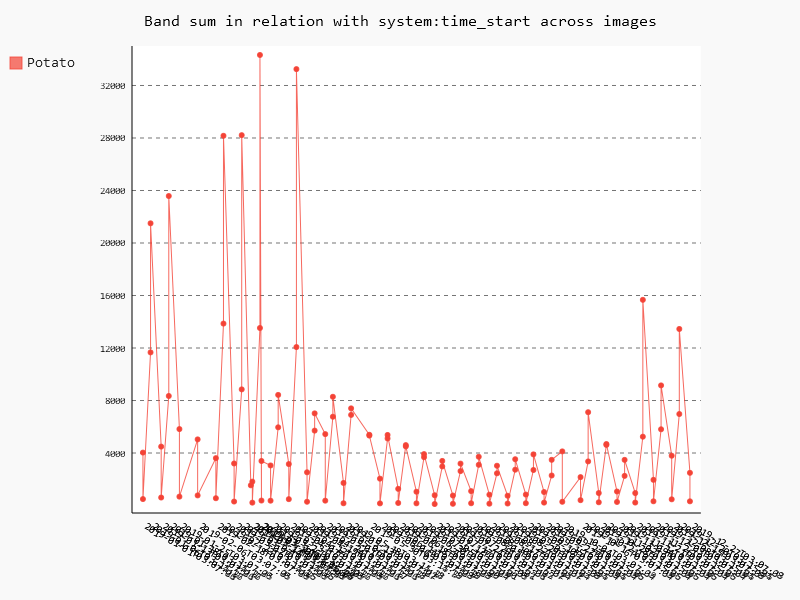

In [8]:
### Classifier built around co polarization vh and vv for Potato
def classifier(img):
    vv = img.select('VV').add(img.select('VH'))
    Potato = vv.gt(-17.595).And(vv.lt(-16.437)).rename('Potato') #pick all pixels below threshold and set them equal to 1. All other pixels set to 0
    Potato = Potato.updateMask(Potato) #Remove all pixels equal to 0
    return img.addBands(Potato)#Return image with added classified potatto band
vv_classifier_Potato= S1_Collection.map(classifier)

#Make time series of tobacco pixels within region with vh
ClassChart = ui.chart.Image.series(**{'imageCollection': vv_classifier_Potato.select('Potato'),'region': AOI, 'reducer': ee.Reducer.sum(),'scale': 100,'maxPixels':1e9, 'bestEffort':True})#.setOptions({title: 'Inundated Pixels', hAxis: {'title': 'Date'}, vAxis: {'title': 'Number of Inundated Pixels'},lineWidth: 2}))

ClassChart.renderWidget(width='100%')
#Define the color pallets and add to the map
vis_pot = {min: -20,max: 0,'palette': ['#ff9100']}
classifiedmap.addLayer( vv_classifier_Potato.select('Potato').median(),vis_pot,'Potato farms')
ClassChart

In [9]:
### Classifier built around co polarization vh and vv for forest
def classifier(img):
    v = img.select('VV')#.add(img.select('VH'))
    water = v.lt(-25).rename('water') #pick all pixels below threshold and set them equal to 1. All other pixels set to 0
    water = water.updateMask(water) #Remove all pixels equal to 0
    return img.addBands(water)#Return image with added classified tobacco band
v_classifier_water = S1_Collection.map(classifier)

ClassChart = ui.chart.Image.series(**{'imageCollection': v_classifier_water.select('water'),'region': AOI, 'reducer': ee.Reducer.sum(),'scale': 100,'maxPixels':1e9, 'bestEffort':True})#.setOptions({title: 'Inundated Pixels', hAxis: {'title': 'Date'}, vAxis: {'title': 'Number of Inundated Pixels'},lineWidth: 2})
  
#Map.add(ClassChart)
ClassChart.renderWidget(width='100%')

vis_water = {min: -20,max: 0,'palette': ['#1100ff']}
classifiedmap.addLayer( v_classifier_water.select('water').median(),vis_water,'Water')

In [10]:
#Area of study area
print('Study area in SqKm is:', AOI.area().divide(1e6).round().getInfo())
#Area covered by potatoes
Potato = vv_classifier_Potato.first()
PotatoArea = Potato.multiply(ee.Image.pixelArea().divide(1e6))
area = PotatoArea.reduceRegion(**{'reducer':ee.Reducer.sum(), 'geometry':AOI, 'scale': 100, 'maxPixels':1e10})
areaSqkm = ee.Number(area.get('Potato')).round().getInfo()
print ('Area covered by potato in Sqkm is', areaSqkm)
#Area covered by Tobacco
Tobacco = vvvh_classifier_Tobacco.first()
TobaccoArea = Tobacco.multiply(ee.Image.pixelArea().divide(1e6))
area =TobaccoArea.reduceRegion(**{'reducer':ee.Reducer.sum(), 'geometry':AOI, 'scale': 100, 'maxPixels':1e10})
areaSqkm = ee.Number(area.get('Tobacco')).round().getInfo()
print ('Area covered by tobacco in Sqkm is', areaSqkm)
#Area covered by banana
Banana = vv_classifier_Banana.first()
BananaArea = Banana.multiply(ee.Image.pixelArea().divide(1e6))
area = BananaArea.reduceRegion(**{'reducer':ee.Reducer.sum(), 'geometry':AOI, 'scale': 100, 'maxPixels':1e10})
areaSqkm = ee.Number(area.get('Banana')).round().getInfo()
print ('Area covered by banana in Sqkm is', areaSqkm)

Study area in SqKm is: 18790
Area covered by potato in Sqkm is 40
Area covered by tobacco in Sqkm is 131
Area covered by banana in Sqkm is 170


In [11]:
keys = ['Tobacco: area 131sqkm', 'Banana: area 170sqkm', 'Potatos: area 40sqkm','Water']
 
colors = ['#f44336', '#8fce00', '#ff9100','#1100ff']

classifiedmap.add_legend(legend_title='Crop type',legend_keys=keys, legend_colors=colors)
classifiedmap

Map(center=[-13.352479341867271, 35.51879882812497], controls=(WidgetControl(options=['position', 'transparent…